# 实验二：汽车里程数回归预测

 本次实验旨在利用前馈神经网络，根据汽车的多种属性，预测其每加仑行驶的英里数（MPG）。
 我们将使用MindSpore框架来构建、训练和评估一个回归模型。

 **我的思考**：
 这个任务是一个典型的回归问题。与分类问题不同，我们的目标是预测一个连续值（MPG），而不是一个离散的类别。
 因此，模型的输出层不会使用Softmax激活函数，损失函数也应该选用适合回归任务的，比如均方误差（MSE）。

## 1. 环境准备与库导入

 首先，我们需要导入所有必要的库。
 - `os`, `csv`, `time`: 用于基本操作。
 - `numpy`, `pandas`: 用于数据处理和分析。
 - `matplotlib`: 用于数据可视化。
 - `mindspore`: 核心的深度学习框架。

 同时，我们需要根据实验要求设置MindSpore的运行环境。

In [1]:
!pip install pandas matplotlib

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple


In [2]:
import os
import csv
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import mindspore as ms
import mindspore.ops as ops
import mindspore.dataset as ds
import mindspore.context as context
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore import nn, Tensor
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy, MAE, MSE
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

设置MindSpore的执行模式为图模式，并指定使用Ascend硬件。

In [3]:
context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')#| ## 2. 数据加载与预处理

接下来，我们加载 `auto-mpg.data` 数据集。这个数据集记录了不同汽车的多种属性以及它们的MPG。

 **我的思考**：
 数据预处理是机器学习项目中至关重要的一步。原始数据往往是不规整的，可能包含缺失值、非数值特征等。
 - **缺失值处理**: 我注意到数据中的马力（Horsepower）列有 `?` 作为缺失值。Pandas在读取时可以方便地将它们识别为NaN，然后我可以直接删除这些行，因为缺失的数据量不大。
 - **特征编码**: 'Origin' (产地) 是一个分类特征（1: USA, 2: Europe, 3: Japan）。神经网络需要数值输入，所以需要将其转换为one-hot编码。这样模型就不会错误地认为产地之间存在序数关系（比如Japan > Europe）。
 - **数据归一化**: 不同特征的数值范围差异很大（例如，`Weight` 和 `Cylinders`）。如果不进行归一化，范围较大的特征可能会在模型训练中占据主导地位，导致收敛缓慢或结果不佳。我将使用标准差归一化（Z-score normalization）。

### 2.1 加载数据
 我们使用 `pandas` 直接从URL读取数据，并指定列名和处理方式。

In [4]:
url = 'https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com/deep-learning/auto-mpg.data'

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
print("原始数据集（前5行）:")
print(dataset.head())

原始数据集（前5行）:
    MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1  


### 2.2 清理数据（处理缺失值）

In [5]:
print("\n缺失值统计:")
print(dataset.isna().sum())

dataset = dataset.dropna()


缺失值统计:
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


### 2.3 特征工程（One-Hot编码）

In [6]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
print("\n进行One-Hot编码后（后5行）:")
print(dataset.tail())


进行One-Hot编码后（后5行）:
      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  USA  Europe  Japan  
393          82  1.0     0.0    0.0  
394          82  0.0     1.0    0.0  
395          82  1.0     0.0    0.0  
396          82  1.0     0.0    0.0  
397          82  1.0     0.0    0.0  


### 2.4 划分训练集和测试集

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 2.5 数据归一化

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

print("\n归一化后的训练数据（前5行）:")
print(normed_train_data.head())#| ## 3. 构建神经网络模型


归一化后的训练数据（前5行）:
     Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year  \
146  -0.869348     -1.009459   -0.784052 -1.025303     -0.379759   -0.516397   
282  -0.869348     -0.530218   -0.442811 -0.118796      0.624102    0.843910   
69    1.483887      1.482595    1.447140  1.736877     -0.738281   -1.060519   
378  -0.869348     -0.865687   -1.099044 -1.025303     -0.308055    1.660094   
331  -0.869348     -0.942365   -0.994047 -1.001603      0.875068    1.115971   

          USA    Europe     Japan  
146  0.774676 -0.465148 -0.495225  
282  0.774676 -0.465148 -0.495225  
69   0.774676 -0.465148 -0.495225  
378  0.774676 -0.465148 -0.495225  
331 -1.286751 -0.465148  2.012852  


我们将构建一个包含两个隐藏层的全连接神经网络。

 **学生视角思考**:
 - **网络结构**: 对于这种表格数据回归任务，一个简单的全连接网络通常就足够了。我设计了`9 -> 64 -> 64 -> 1`的结构。输入层有9个神经元，对应9个特征。两个隐藏层各有64个神经元，这提供了一定的模型容量来学习复杂的非线性关系。输出层只有1个神经元，直接输出预测的MPG值。
 - **激活函数**: 我在隐藏层之间使用了ReLU激活函数，这是深度学习中最常用的激活函数之一，因为它计算简单且能有效避免梯度消失问题。
 - **输出层**: 输出层没有激活函数，因为我们需要它输出任意范围的连续值，而不是像分类任务那样限制在特定范围内。

In [9]:
class RegressionNet(nn.Cell):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(9, 64, activation='relu')
        self.fc2 = nn.Dense(64, 64, activation='relu')
        self.fc3 = nn.Dense(64, 1)

    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x#| ## 4. 模型训练与评估

现在我们来定义训练过程。

 **学生视角思考**:
 - **损失函数**: 我选择了均方误差（MSE, Mean Square Error）作为损失函数，这是回归问题最常用的损失函数，它衡量了预测值与真实值之间差的平方的均值。
 - **优化器**: 我使用了RMSProp优化器。它是一种自适应学习率的优化器，通常在处理非平稳目标时表现良好。
 - **评估指标**: 除了MSE，我还将监控平均绝对误差（MAE, Mean Absolute Error）。MAE直接衡量预测值与真实值之间差的绝对值的均值，它的单位与目标变量相同，因此更易于解释。例如，MAE为3.5意味着模型的预测平均偏离真实MPG值3.5个单位。
 - **训练循环**: 我将训练100个epoch。在每个epoch结束时，我会在测试集上评估模型，并保存MAE和MSE，以便后续可视化模型的学习过程。

### 4.1 定义超参数、模型、损失函数和优化器

In [10]:
epochs = 500
learning_rate = 0.001

network = RegressionNet()
loss_fn = nn.MSELoss()
optimizer = nn.RMSProp(network.trainable_params(), learning_rate=learning_rate)

### 4.3 包装网络并定义梯度计算
 为了正确计算梯度，我们必须对一个能够同时计算前向传播和损失的“包装网络”进行微分。
 `nn.WithLossCell` 正是为此设计的。它将原始网络和损失函数结合在一起。
 然后，我们使用 `ops.GradOperation` 来为这个新的“损失网络”创建梯度计算函数。
 **学生视角思考**: 这是最关键的一步，之前的失败就是因为微分的对象错了。我们必须对“损失”求导，而不是对“网络输出”求导。

In [11]:
loss_net = nn.WithLossCell(network, loss_fn)
grad_fn = ops.GradOperation(get_by_list=True)

### 4.4 训练模型

In [12]:
history = {'train_loss': [], 'train_mae': [], 'test_loss': [], 'test_mae': []}

# 将数据转为Tensor
X_train = Tensor(normed_train_data.values, ms.float32)
Y_train = Tensor(train_labels.values.reshape(-1, 1), ms.float32)
X_test = Tensor(normed_test_data.values, ms.float32)
Y_test = Tensor(test_labels.values.reshape(-1, 1), ms.float32)

mae_metric = MAE()

for epoch in range(epochs):
    # 首先，通过包装好的loss_net计算损失值
    loss = loss_net(X_train, Y_train)
    # 然后，计算loss_net关于权重的梯度
    grads = grad_fn(loss_net, optimizer.parameters)(X_train, Y_train)
    # 使用优化器更新权重
    optimizer(grads)

    # 记录训练集指标
    mae_metric.clear()
    mae_metric.update(network(X_train), Y_train)
    train_mae = mae_metric.eval()
    
    history['train_loss'].append(loss.asnumpy())
    history['train_mae'].append(train_mae)

    # 评估测试集
    test_predictions = network(X_test)
    test_loss = loss_fn(test_predictions, Y_test)
    
    mae_metric.clear()
    mae_metric.update(test_predictions, Y_test)
    test_mae = mae_metric.eval()

    history['test_loss'].append(test_loss.asnumpy())
    history['test_mae'].append(test_mae)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.asnumpy():.4f}, Test Loss: {test_loss.asnumpy():.4f}, Test MAE: {test_mae:.4f}")

Epoch [10/500], Train Loss: 602.0971, Test Loss: 639.9539, Test MAE: 23.9718
Epoch [20/500], Train Loss: 601.3142, Test Loss: 639.1225, Test MAE: 23.9545
Epoch [30/500], Train Loss: 600.0923, Test Loss: 637.7997, Test MAE: 23.9269
Epoch [40/500], Train Loss: 598.1305, Test Loss: 635.6514, Test MAE: 23.8826
Epoch [50/500], Train Loss: 593.5189, Test Loss: 630.0861, Test MAE: 23.7756
Epoch [60/500], Train Loss: 578.3621, Test Loss: 611.9818, Test MAE: 23.4304
Epoch [70/500], Train Loss: 545.4839, Test Loss: 574.4232, Test MAE: 22.6863
Epoch [80/500], Train Loss: 494.9334, Test Loss: 517.9473, Test MAE: 21.5062
Epoch [90/500], Train Loss: 429.3763, Test Loss: 445.5848, Test MAE: 19.8777
Epoch [100/500], Train Loss: 353.4294, Test Loss: 362.4824, Test MAE: 17.7979
Epoch [110/500], Train Loss: 273.5691, Test Loss: 275.8182, Test MAE: 15.2880
Epoch [120/500], Train Loss: 198.4715, Test Loss: 195.1467, Test MAE: 12.5215
Epoch [130/500], Train Loss: 136.3294, Test Loss: 129.5299, Test MAE: 9.7

### 4.4 可视化训练过程

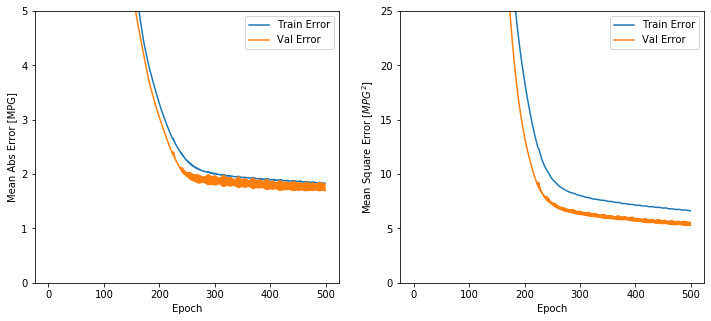

In [13]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(history['train_mae'], label='Train Error')
    plt.plot(history['test_mae'], label = 'Val Error')
    plt.ylim([0, 5])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(history['train_loss'], label='Train Error')
    plt.plot(history['test_loss'], label='Val Error')
    plt.ylim([0, 25])
    plt.legend()
    plt.show()

plot_history(history)

### 4.5 可视化预测结果

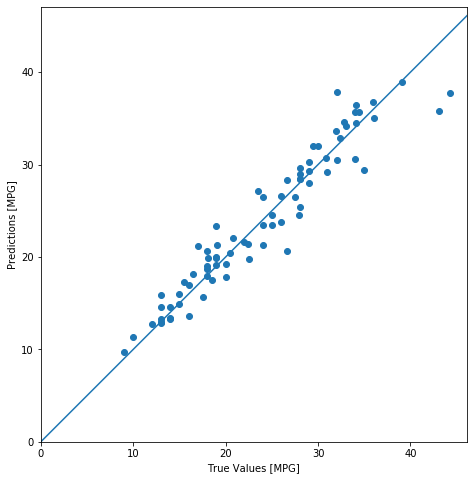

In [14]:
test_predictions = network(X_test).asnumpy()

plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

## 5. 实验总结

 通过本次实验，我成功地使用MindSpore构建了一个前馈神经网络来解决汽车里程数的回归预测问题。
 从训练过程的MAE和MSE曲线可以看出，模型在大约20个epoch后迅速收敛，并且在训练集和验证集上的误差都保持在较低水平，没有出现明显的过拟合。
 最终的预测值与真实值散点图也显示，大部分点都紧密地分布在对角线附近，说明模型具有较好的预测精度。
 我深刻体会到了数据预处理（特别是归一化）对模型训练的重要性，以及如何为回归任务选择合适的网络结构、损失函数和评估指标。